# PARTE 1. Priorizar hipótesis

In [1]:
import pandas as pd 

hypotheses = pd.read_csv("/datasets/hypotheses_us.csv", sep=";")
#pd.set_option('display.max_colwidth', None)

hypotheses['ICE'] = (hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']
print(hypotheses[["Hypothesis", "ICE"]].sort_values(by="ICE", ascending=False))

hypotheses["RICE"] = (hypotheses["Reach"]*hypotheses["Impact"]*hypotheses["Confidence"])/hypotheses["Effort"]
print(hypotheses[["Hypothesis","RICE"]].sort_values(by="RICE", ascending=False))


                                          Hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000
                                          Hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2


Al usar la metodología RICE, la hipótesis 7 (Añadir un formulario de suscripción a todas las páginas principales) tiene mayor prioridad. La hipótesis 8 tenía mayor importancia en la metodología ICE, mientras que en RICE esta cae a la posición 5. Mientras que la metodología ICE prioriza las hipotesis con base en el esfuerzo, RICE también considera el alcance. 

# PARTE 2. Análisis del test A/B 

## Preprocesamiento de los datos

### 1. Representa gráficamente el ingreso acumulado por grupo. Haz conclusiones y conjeturas.

In [2]:
import datetime as dt
import numpy as np

orders = pd.read_csv("/datasets/orders_us.csv")
visits = pd.read_csv("/datasets/visits_us.csv")

orders["date"] = orders["date"].map(
    lambda x: dt.datetime.strptime(x, "%Y-%m-%d")
)
visits["date"] = visits["date"].map(
    lambda x: dt.datetime.strptime(x, "%Y-%m-%d")
)
print(orders.head())
print(visits.head())

   transactionId   visitorId       date  revenue group
0     3667963787  3312258926 2019-08-15     30.4     B
1     2804400009  3642806036 2019-08-15     15.2     B
2     2961555356  4069496402 2019-08-15     10.2     A
3     3797467345  1196621759 2019-08-15    155.1     B
4     2282983706  2322279887 2019-08-15     40.5     B
        date group  visits
0 2019-08-01     A     719
1 2019-08-02     A     619
2 2019-08-03     A     507
3 2019-08-04     A     717
4 2019-08-05     A     756


In [3]:
# Matrix con parejas fecha-grupo únicos 

datesGroups = orders[["date", "group"]].drop_duplicates()
# obtener filas del df orders donde la fecha es igual o menor que el elemento en datesGroups para estimar los resultados agregados
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders["date"]<= x["date"], orders["group"]==x["group"])].agg(
    {"date":"max", "group":"max", "transactionId":pd.Series.nunique, "visitorId":pd.Series.nunique, "revenue":"sum"}), axis=1).sort_values(by=["date", "group"])
print(ordersAggregated.head())


          date group  transactionId  visitorId  revenue
55  2019-08-01     A             24         20   2356.8
66  2019-08-01     B             21         20   1620.0
175 2019-08-02     A             44         38   3860.3
173 2019-08-02     B             45         43   4243.8
291 2019-08-03     A             68         62   5675.5


In [4]:
# obtener datos diarios acumulados sobre las visitas 
visitorsAggregated = datesGroups.apply(lambda x:visits[np.logical_and(visits["date"]<= x["date"], visits["group"]== x["group"])].agg(
    {"date":"max", "group":"max", "visits":"sum"}),axis =1).sort_values(by=["date", "group"])
# merge both tables

cumulativeData = ordersAggregated.merge(visitorsAggregated,on=["date", "group"])
cumulativeData.columns=["date", "group", "orders", "buyers", "revenue", "visitors"]
print(cumulativeData.head(10))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   2356.8       719
1 2019-08-01     B      21      20   1620.0       713
2 2019-08-02     A      44      38   3860.3      1338
3 2019-08-02     B      45      43   4243.8      1294
4 2019-08-03     A      68      62   5675.5      1845
5 2019-08-03     B      61      59   6050.6      1803
6 2019-08-04     A      84      77   6822.1      2562
7 2019-08-04     B      78      75   7767.9      2573
8 2019-08-05     A     109     100   8810.2      3318
9 2019-08-05     B     101      98   9262.9      3280


In [5]:
print(cumulativeData["date"].max())
print(cumulativeData["date"].min())

2019-08-31 00:00:00
2019-08-01 00:00:00


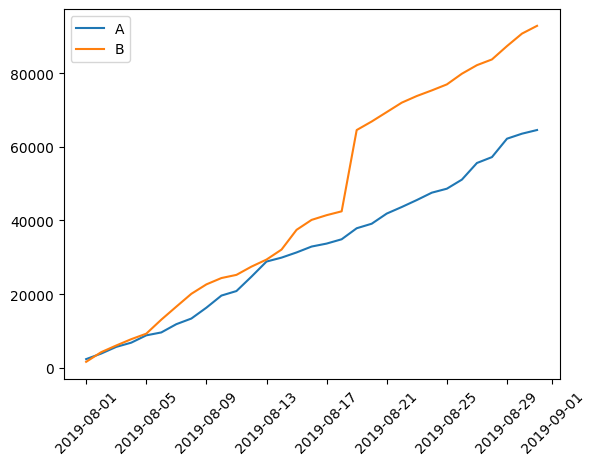

In [6]:

# Gráficas con ingreso acumulado por día y grupo

import matplotlib.pyplot as plt

# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Trazar el gráfico de ingresos del grupo A
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Trazar el gráfico de ingresos del grupo B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=45) 
plt.legend()
 


Para ambos grupos los ingresos aumentan constantemente durante toda la prueba aunque se observan mayores ingresos para el grupo B.

### 2.Representa gráficamente el tamaño de pedido promedio acumulado por grupo. Haz conclusiones y conjeturas.

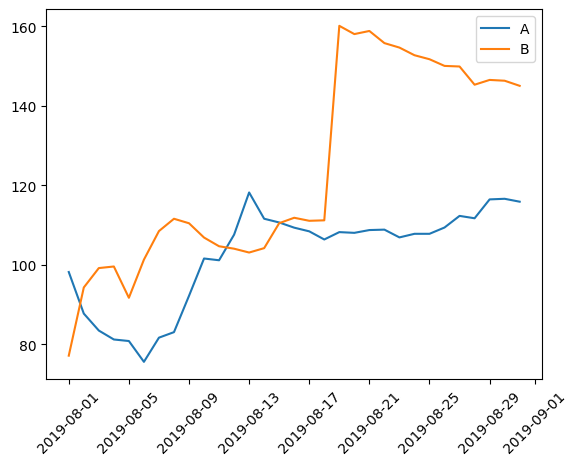

In [7]:
# Primero trazamos el tamaño promedio de compra por grupo. 
# Después dividimos los ingresos acumulados entre el número acumulado de pedidos

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45) 
plt.legend()

El tamaño de compra promedio parece ser mayor para el grupo B.

### 3. Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A. Haz conclusiones y conjeturas.

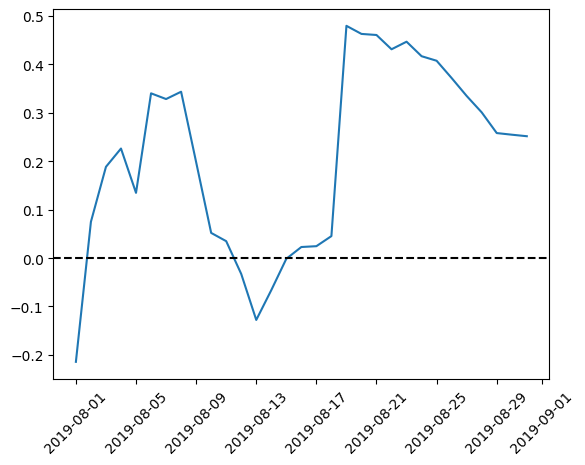

In [8]:
# Trazamos gráfico de diferencia relativa para los tamaños promedio de compra. Agregaremos un eje horizontal con el método axhline() (es decir, una línea horizontal a lo largo del eje):
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# trazar un gráfico de diferencia relativa para los tamaños de compra promedio
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xticks(rotation=45) 
# agregar el eje X
plt.axhline(y=0, color='black', linestyle='--')


El grupo B tiene un tamaño de compra promedio mayor que en el grupo A. La diferencia máxima alcanza hasta 50%.

### 4. Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia. Saca conclusiones y haz conjeturas

(18109.0, 18139.0, 0.02, 0.04)

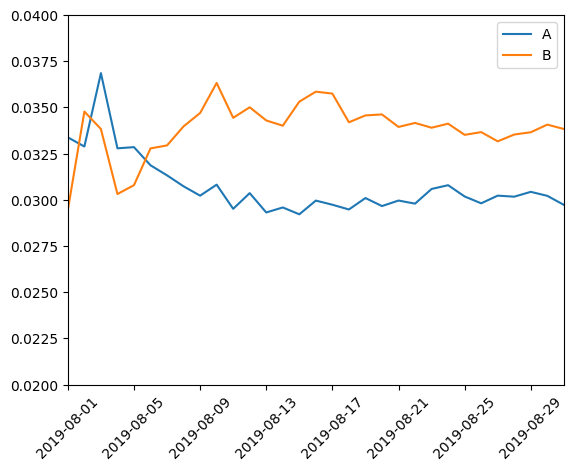

In [9]:
# Analizaremos el gráfico de conversión acumulada de forma similar. Escalemos los ejes con el método plt.axis(), 
# pasando los valores mínimo y máximo del eje X y los valores mínimo y máximo
# del eje Y al método: ["2019-04-01", '2019-04-23', 0, 0.015]

# Asegurar formato datetime
cumulativeData['date'] = pd.to_datetime(cumulativeData['date'])

# Calcular conversión acumulada
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

# Filtrar por grupo
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

# Trazar
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label="A")
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xticks(rotation=45)

# Ajustar escala pasando valores mínimo y máximo del eje X y los valores mínimo y máximo del eje Y al método: 
plt.axis([pd.to_datetime("2019-08-01"), pd.to_datetime("2019-08-31"), 0.02, 0.04])



En cuanto a la tasa de conversión de cada grupo, al inicio de la prueba el grupo A tenía una tasa de conversión más alta pero el grupo B ganó gradualmente y se estabilizó entre el 3.25% y 3.5%

### 5. Traza un gráfico de dispersión del número de pedidos por usuario. Haz conclusiones y conjeturas.

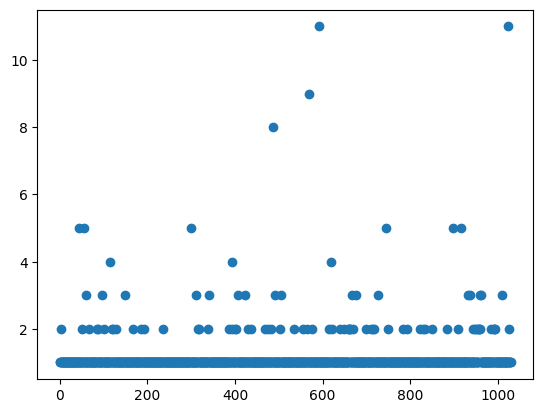

In [10]:
import matplotlib.pyplot as plt

ordersByUsers = (
    orders.groupby("visitorId", as_index=False)
    .agg({"transactionId":pd.Series.nunique}))
ordersByUsers.columns=["userId", "orders"]

x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers["orders"])

A partir del gráfico de dispersión podemos observar que la mayoría de clientes realiza hasta 3 pedidos. Hay pocos usuarios que realicen más de 3 pedidos (hasta 11). El gráfico no permite saber el porcentaje de usuarios que hicieron pedidos atípicos por lo que no podemos decir con certeza que 3 pedidos son anómalos. 

### 6. Calcula los percentiles 95 y 99 del número de pedidos por usuario. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [11]:
import numpy as np

print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


No más del 5% de los usuarios realizaron màs de 2 pedidos & no más del 1% de los usuarios realizaron más de 4 pedidos. Por lo tanto, 3 o más pedidos puede considerarse como un valor atípico.

### 7. Traza un gráfico de dispersión de los precios de los pedidos. Haz conclusiones y conjeturas.

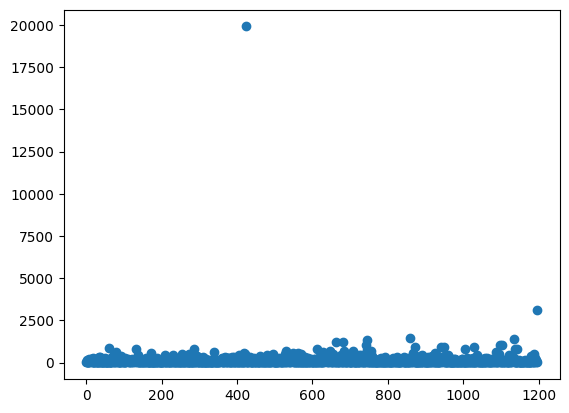

In [12]:

x_values = pd.Series(range(0,len(orders["revenue"])))
plt.scatter(x_values, orders["revenue"])

#### La mayoría de pedidos no superan el monto total de 2500. Claramente un pedido de 2500 o más podría considerarse atípico. para asegurarnos podemos calcular los percentiles de los precios de los pedidos.

### 8. Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [13]:
print(np.percentile(orders['revenue'], [95, 99]))

[435.54  900.904]


No más del 5% de pedidos cuestán más de 435.5 y no más del 1% de pedidos cuestan más de $900. Por lo tanto, un pedido de más de 435 podría considerarse anómalo.

### 9. Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.

In [14]:
import scipy.stats as stats

ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.017
0.138


El valor p 0.017 es menor que 0.05, por lo que podemos rechazar la hipótesis nula y concluímos que hay una diferencia estadísticamente significativa entre los grupos. De hecho, la ganancia relativa del grupo B es del 13.8%

### 10. Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.

In [15]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.692
0.252


El valor p es superior a 0.05, por lo que no podemos rechazar la hipótesis nula ni confirmar una diferencia significativa entre el tamaño promedio de compra de ambos grupos. No obstante, el tamaño promedio de compra para el grupo B es 25% mayor que para el grupo A.


### 11. Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.

In [16]:
# Vamos a encontrar el número total de usuarios anómalos con el método shape(). 
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 3]['visitorId'], ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 435]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

# Calcularemos la significancia estadística de las diferencias en la conversión entre los grupos con datos filtrados. Primero prepararemos muestras del número de pedidos por usuario para cada grupo de prueba:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
Name: visitorId, dtype: int64
(62,)
0.020
0.158


En total tenemos 62 pedidos anómalos. Estos fueron usuarios con 3 o más pedidos y ordenes con un valor de compra superior a 435. Tras calcular la significancia estadística con los datos filtrados, observamos que el valor p no cambió mucho en este caso (de 0.017 a 0.02) El valor p sigue siendo menor a 0.05 por lo que podemos rechazar la hipótesis nula y concluir que existe una diferencia entre los grupos, donde la ganancia relativa del grupo B es de 15.8% (antes 13.8%)

### 12. Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.

In [17]:
# Muestra el valor p calculado con la prueba U de Mann-Whitney
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',  # Selecciona datos en el grupo A
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],  # Excluye los usuarios anormales y selecciona los datos de ingreso para el grupo A
    orders[np.logical_and(
        orders['group']=='B',  # Selecciona datos en el grupo B
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']  # Excluye los usuarios anormales y selecciona los datos de ingreso para el grupo B
)[1]))  # Extrae el valor p de los resultados de la prueba

# Muestra la diferencia relativa en el ingreso medio entre los grupos B y A
print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',  # Selecciona datos en el grupo B
           np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() /  # Calcula el ingreso medio para el grupo B
    orders[np.logical_and(orders['group']=='A',  # Selecciona datos en el grupo A
           np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))  # Calcula el ingreso medio para el grupo A y muestra la diferencia relativa          

0.939
-0.028


Tras filtrar los datos anómalos en el tamaño promedio de compra el valor p aumentó, por lo que no podemos rechazar la hipótesis nula y concluir que hay una diferencia entre los grupos. Aunque, la diferencia en el promedio de compra entre los segmentos ahora es de casi -3% en lugar de  25% para el grupo B.

### 13. Toma una decisión basada en los resultados de la prueba. Las decisiones posibles son: 1. Parar la prueba, considerar a uno de los grupos como líder. 2. Parar la prueba, concluir que no hay diferencia entre los grupos. 3. Continuar la prueba.

-Tanto los datos sin procesar como los datos filtrados (sin valores anómalos) muestran una diferencia estadísticamente significativa para la conversión entre los grupos. La ganancia relativa del grupo B es de 15.8%.
-En cuanto al tamaño promedio de los pedidos, los datos sin procesar no mostraron una diferencia significativa. Sin embaro, al filtrar los valores anómalos se reveló una diferencia estadísticamente significativa en el tamaño promedio de los pedidos entre los grupos. El tamaño de compra del grupo B es 3% menor que el grupo A.
-De igual forma, el gráfico que muestra la diferencia de conversión entre los grupos indica que el grupo B tuvo una mejor tasa de conversión a lo largo del tiempo. 
-En cuanto a la la diferencia en el tamaño promedio de los pedidos entre los grupos, el gráfico muestra que el tamaño promedio de compra del grupo B es más alto que el grupo A.

A partir de estos hallazgos, lo más sensato sería parar la prueba y concluir que los resultados del grupo B son mejores en general que los resultados del grupo A. 